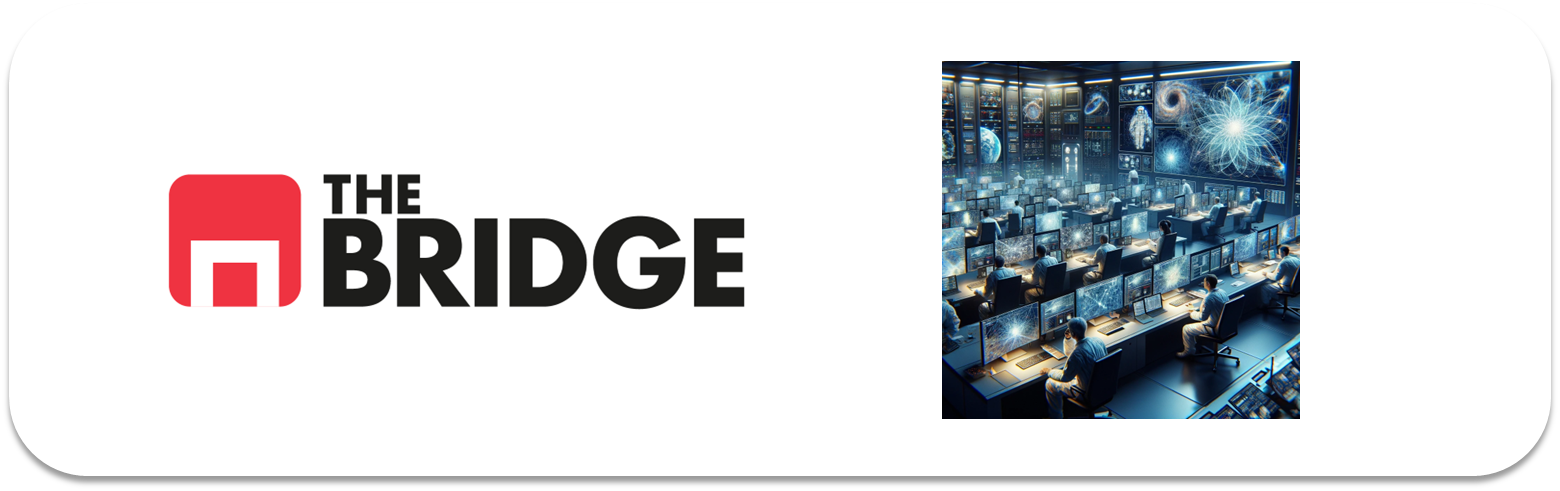

## PRACTICA OBLIGATORIA: **Transfer Learning y Fine Tuning**

* La práctica obligatoria de esta unidad consiste en un repetir el ejercicio de construcción de un modelo de clasificación de paisajes pero usando un modelo preentrenado. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.utils import shuffle
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from keras.preprocessing.image import ImageDataGenerator
from skimage.io import imread
from keras import layers
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from tensorflow.keras import Model
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.resnet_v2 import decode_predictions
import pandas as pd
# ignore warnings
import warnings
warnings.filterwarnings("ignore")



import seaborn as sns
from sklearn.metrics import confusion_matrix
import keras
import cv2

ME HA PETADO EL VISUAL CON EL MODELO, ASÍQUE USARÉ EL RESNETV50

### Objetivo del ejercicio

Comparar una red convolucional hecha ad-hoc frente a los modelos preentrenados y ajustados con fine tuning y transfer learning. Para ello emplea el dataset de paisajes del conjunto de ejercicios de la unidad anterior.


### Se pide

1. Preparar los datos del modelo y las funciones de visualización, copia para ello todo lo que necesites de las soluciones del ejercicio de clasificación de paisajes de la unidad anterior.

2. Escoger entre uno de los modelos VGG-19, InceptionV3 y MobileNetV2 (todos en https://keras.io/api/applications/) (Se aconseja este último si no tenemos un ordenador muy potente). Si no te haces con estos puedes recurrir a la ResNetV50.

4. Hacer un transfer-learning con una cabeza de como mucho 2 capas densas ocultas y una de salida. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

5. Hacer un fine-tuning con la misma cabeza diseñada en el punto anterior. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

6. Comparar los resultados con los obtenidos con la red convolucional del ejercicio mencionado.

EXTRA:
- Repetir el transfer learning empleando aumentado de imágenes.



1. Preparar los datos del modelo y las funciones de visualización, copia para ello todo lo que necesites de las soluciones del ejercicio de clasificación de paisajes de la unidad anterior.

In [2]:
ROOT_PATH = './data/'
TRAIN_PATH = ROOT_PATH + "seg_train/"
TEST_PATH = ROOT_PATH + "seg_test/"


In [3]:
def read_data(directorio, reshape_dim = (32,32)):
    X = [] 
    y = []
    for folder in os.listdir(directorio):
        print(folder)
        if os.path.isdir('/'.join([directorio, folder])):
            for file in os.listdir('/'.join([directorio, folder])):

                image = imread('/'.join([directorio, folder, file]))
                image = cv2.resize(image, reshape_dim) # Redimensionamos las imágenes a 32x32

                X.append(image)
                y.append(folder)

    return np.array(X),np.array(y)

In [4]:
X_train,y_train = read_data(TRAIN_PATH)
X_test, y_test = read_data(TEST_PATH) 

buildings
forest
glacier
mountain
sea
street
buildings
forest
glacier
mountain
sea
street


In [5]:
print('X train shape: ', X_train.shape)
print('Y train shape: ', y_train.shape)

X train shape:  (14034, 32, 32, 3)
Y train shape:  (14034,)


In [6]:
print('X train shape: ', X_test.shape)
print('Y train shape: ', y_test.shape)

X train shape:  (3000, 32, 32, 3)
Y train shape:  (3000,)


In [7]:
def show_images_batch(paisajes, names = [], n_cols = 5, size_scale = 2):
    n_rows = ((len(paisajes) - 1) // n_cols + 1)
    plt.figure(figsize=(n_cols * size_scale, n_rows * 1.1*size_scale))
    for index, paisaje in enumerate(paisajes):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(paisaje, cmap = "Greys")
        plt.axis("off")
        if len(names):
            plt.title(names[index])

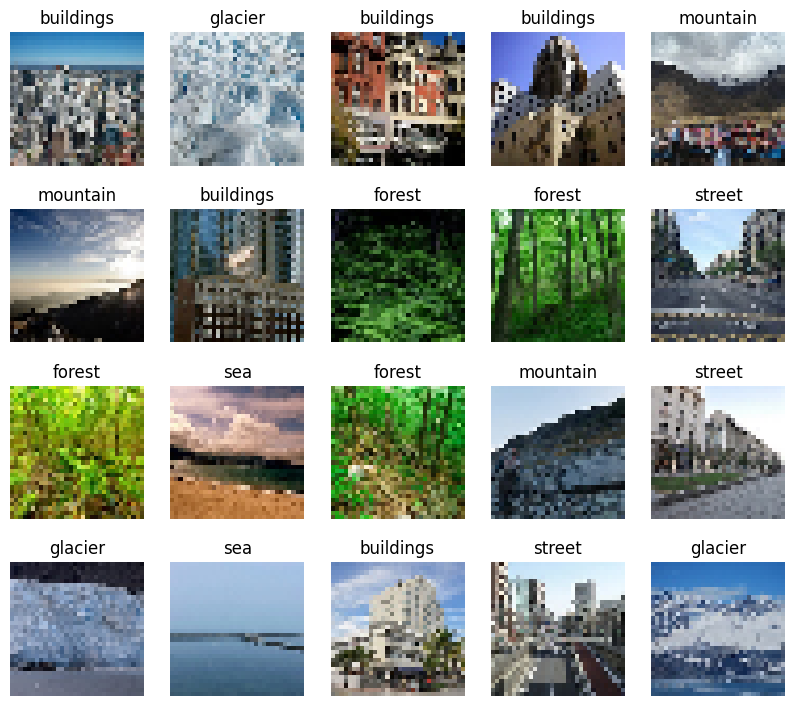

In [8]:
indices = np.random.randint(0,len(X_train),20)
show_images_batch(X_train[indices], names = y_train[indices], n_cols = 5)

In [9]:
# Cargamos los datos de test
X_test_224 = []
y_test_224 = []

for category in os.listdir(TEST_PATH):
    for file in os.listdir(os.path.join(TEST_PATH, category)):
        img = plt.imread(os.path.join(TEST_PATH, category, file))
        img = cv2.resize(img, (224, 224))
        X_test_224.append(img)
        y_test_224.append(category)

# Transformamos a numpy arrays
X_test_224 = np.array(X_test_224)
y_test_224 = np.array(y_test_224)

muestro imágenes

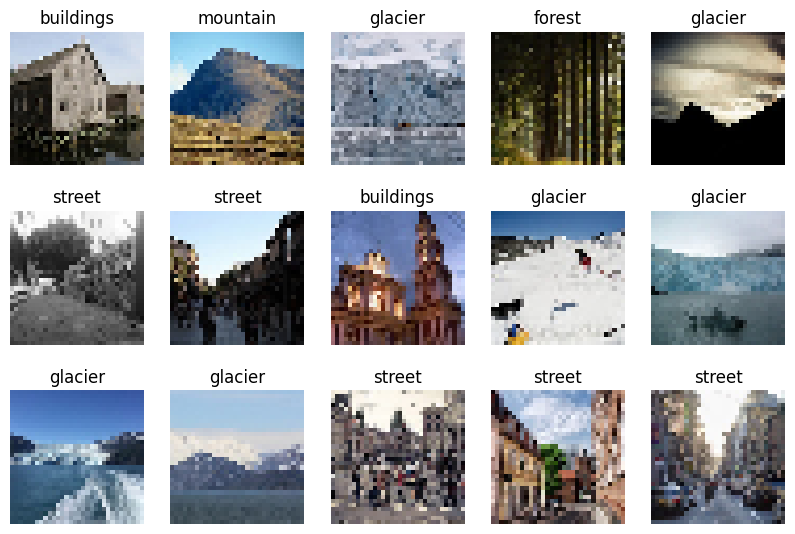

In [27]:
indices = np.random.randint(0,len(X_train),15)
show_images_batch(X_train[indices], y_train[indices])

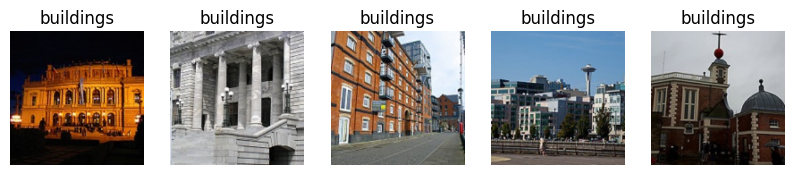

In [12]:
show_images_batch(X_test_224[23:28],y_test_224[23:28])

ESCALO LAS IMÁGENES

In [13]:
X_train = X_train/255
X_test = X_test/255

MINIEDA

In [14]:
targets = pd.Series(y_train)
targets.value_counts(True)

mountain     0.178994
glacier      0.171298
street       0.169731
sea          0.162035
forest       0.161821
buildings    0.156121
Name: proportion, dtype: float64

HACEMOS UN SHUFFLE

In [15]:
# Barajamos los datos, nos interesa hacerlo con train puesto que son a partir de los cuales aprende el modelo
X_train_s, y_train_s = shuffle(X_train, y_train, random_state=42)

MAPEO LAS CATEGORÍAS A NÚMEROS

In [16]:
# Maopeamos las categorías a números
categorias = np.unique(y_train)
n_categorias = len(categorias)

mapping = {cat: i for i, cat in enumerate(categorias)}
inverse_mapping = {valor:clave for clave,valor in mapping.items()}

In [17]:
mapping

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [18]:
inverse_mapping

{0: 'buildings',
 1: 'forest',
 2: 'glacier',
 3: 'mountain',
 4: 'sea',
 5: 'street'}

In [19]:
# Mapeamos las etiquetas
y_train_num = np.array([mapping[cat] for cat in y_train_s])
y_test_num = np.array([mapping[cat] for cat in y_test])

2. Escoger entre uno de los modelos VGG-19, InceptionV3 y MobileNetV2 (todos en https://keras.io/api/applications/) (Se aconseja este último si no tenemos un ordenador muy potente). Si no te haces con estos puedes recurrir a la ResNetV50.


# 4. Hacer un transfer-learning con una cabeza de como mucho 2 capas densas ocultas y una de salida. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

CREO EL MODELO VGG19

In [30]:
#miro el shape que tiene paraa ajustar el modelo
X_train_s.shape

(14034, 32, 32, 3)

In [20]:
#base_model = VGG19(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
#no me ha funcionado, vuelvo con el 

In [31]:
base_model = VGG19(include_top=False, weights='imagenet', input_shape=(32, 32, 3))

In [22]:
#congelo capas
for layer in base_model.layers:
    layer.trainable = False

In [23]:
seleccion = np.random.randint(0,len(X_test_224),20)
predictions = base_model.predict(X_test_224[seleccion])

1/1 [==============================] - 4s 4s/step


In [24]:
predictions.shape

(20, 7, 7, 512)

In [63]:
def prepare_model(base_model = base_model): # Lo creamos así para poder reinicializarlo en cada reentrenamiento en ejercicios posteriores
    x = layers.Flatten()(base_model.output)
    
    # Capa densa con 300 neuronas
    x = layers.Dense(300, activation='relu')(x)
    x = layers.Dropout(rate = 0.5)(x)

    
    # Capa final de salida con 13 neuronas y activación softmax
    x = layers.Dense(13, activation='softmax')(x)
    
    model = Model(base_model.input, x)
    model.compile(optimizer = "adam", loss = 'sparse_categorical_crossentropy', metrics = ['acc'])
    return model
# Observamos la arquitectura del modelo
model= prepare_model()
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0   

In [37]:
earlyS = EarlyStopping(patience= 5, restore_best_weights= True)

In [38]:
X_train_s.shape

(14034, 32, 32, 3)

In [39]:
instancias_train = len(X_train)
for i in range(1,5):
    print(f"Batch_size: {32*i}, num_steps_per_epoch: {round(instancias_train/(32*i))}")

Batch_size: 32, num_steps_per_epoch: 439
Batch_size: 64, num_steps_per_epoch: 219
Batch_size: 96, num_steps_per_epoch: 146
Batch_size: 128, num_steps_per_epoch: 110


In [40]:
batch_size = 64

In [41]:
# Entrenamos el modelo
from time import time
t_zero = time()
model = prepare_model()
history = model.fit(X_train_s, 
                    y_train_num,
                    batch_size = batch_size,
                    validation_split=0.2,
                    epochs=1,)
print(time() - t_zero)



176/176 [==============================] - 195s 1s/step - loss: 1.6750 - acc: 0.2849 - val_loss: 1.1503 - val_acc: 0.4364
195.81493377685547


In [42]:
# Entrenamos el modelo con más épocas y está aumentando la acuracy 
model = prepare_model()
history = model.fit(X_train_s, 
                    y_train_num,
                    batch_size = batch_size,
                    validation_split=0.2,
                    epochs=20,
                   callbacks=[earlyS])

Epoch 1/20
176/176 [==============================] - 198s 1s/step - loss: 1.2692 - acc: 0.4511 - val_loss: 1.0590 - val_acc: 0.5084
Epoch 2/20
176/176 [==============================] - 186s 1s/step - loss: 1.0932 - acc: 0.5096 - val_loss: 1.0387 - val_acc: 0.5094
Epoch 3/20
176/176 [==============================] - 193s 1s/step - loss: 1.0290 - acc: 0.5537 - val_loss: 0.8983 - val_acc: 0.6359
Epoch 4/20
176/176 [==============================] - 196s 1s/step - loss: 0.9156 - acc: 0.6353 - val_loss: 0.8260 - val_acc: 0.6616
Epoch 5/20
176/176 [==============================] - 198s 1s/step - loss: 0.8761 - acc: 0.6588 - val_loss: 0.8942 - val_acc: 0.6413
Epoch 6/20
176/176 [==============================] - 178s 1s/step - loss: 0.8118 - acc: 0.6805 - val_loss: 0.8862 - val_acc: 0.6470
Epoch 7/20
176/176 [==============================] - 179s 1s/step - loss: 0.7556 - acc: 0.7229 - val_loss: 0.7915 - val_acc: 0.7064
Epoch 8/20
176/176 [==============================] - 188s 1s/step - 

In [49]:
history = pd.DataFrame(history.history)
history

AttributeError: 'DataFrame' object has no attribute 'history'

<Axes: >

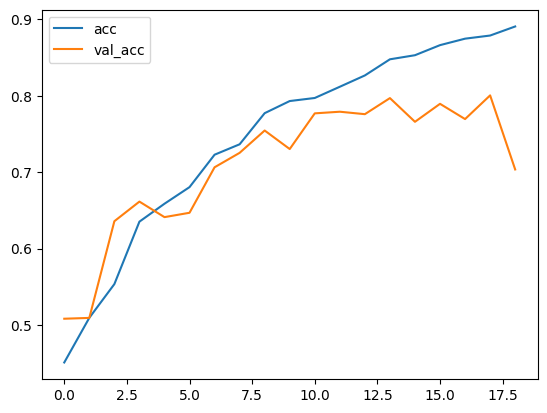

In [48]:
history[["acc","val_acc"]].plot()

<Axes: >

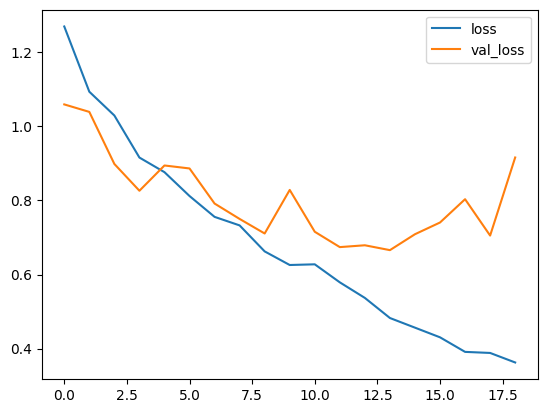

In [50]:
history[["loss","val_loss"]].plot()

In [51]:
earlyS = EarlyStopping(min_delta = 0.001, restore_best_weights= True)

In [52]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

y_pred = [inverse_mapping[np.argmax(prediccion)] for prediccion in model.predict(X_test)]
print(classification_report(y_test, y_pred))

94/94 [==============================] - 12s 126ms/step
              precision    recall  f1-score   support

   buildings       0.77      0.77      0.77       437
      forest       0.96      0.88      0.92       474
     glacier       0.85      0.69      0.76       553
    mountain       0.82      0.72      0.77       525
         sea       0.66      0.88      0.76       510
      street       0.78      0.85      0.82       501

    accuracy                           0.80      3000
   macro avg       0.81      0.80      0.80      3000
weighted avg       0.81      0.80      0.80      3000



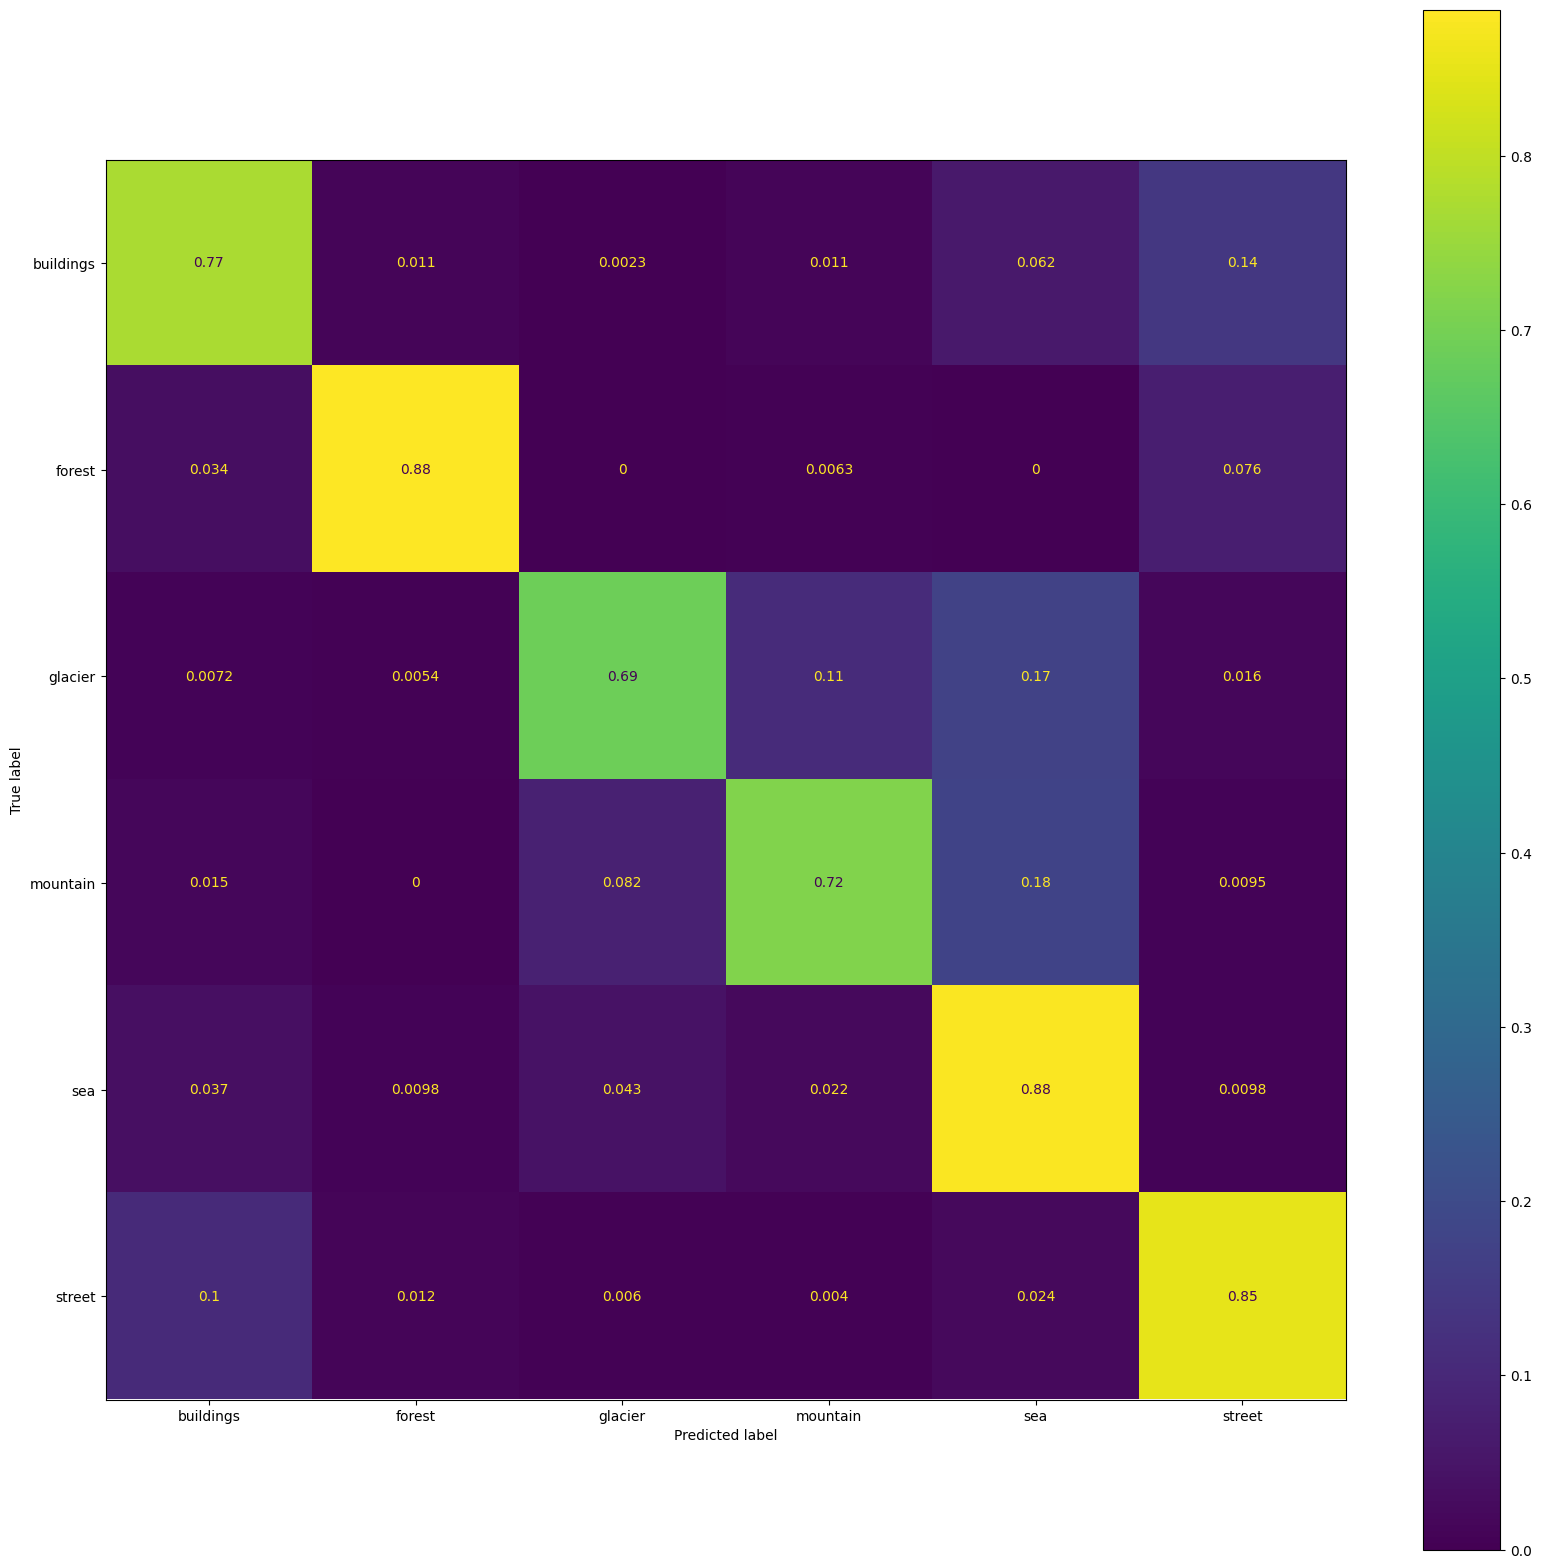

In [53]:
fig,axs = plt.subplots(1,1,figsize = (20,20))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize = "true", ax = axs)

Creo que con las 20 épocas el modelono ha salido delo todo mal


### 5. Hacer un fine-tuning con la misma cabeza diseñada en el punto anterior. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

6. Comparar los resultados con los obtenidos con la red convolucional del ejercicio mencionado.


In [57]:
#cargo el modelo sin entrenamiento
base_model = VGG19(include_top=False, weights='imagenet', input_shape=(32, 32, 3))

Edito la función porque me daba error


In [67]:
def prepare_model(model):
    
    x = layers.Flatten()(model.output)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(rate = 0.5)(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(rate = 0.5)(x)
    x = layers.Dense(6, activation='softmax')(x)
    model = Model(model.input, x)
    model.compile(optimizer = "adam", loss = 'sparse_categorical_crossentropy', metrics = ['acc'])
    
    return model

In [68]:
model_fine = prepare_model(model = base_model)
model_fine.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0   

                                                                 
 block3_conv3 (Conv2D)       (None, 8, 8, 256)         590080    
                                                                 
 block3_conv4 (Conv2D)       (None, 8, 8, 256)         590080    
                                                                 
 block3_pool (MaxPooling2D)  (None, 4, 4, 256)         0         
                                                                 
 block4_conv1 (Conv2D)       (None, 4, 4, 512)         1180160   
                                                                 
 block4_conv2 (Conv2D)       (None, 4, 4, 512)         2359808   
                                                                 
 block4_conv3 (Conv2D)       (None, 4, 4, 512)         2359808   
                                                                 
 block4_conv4 (Conv2D)       (None, 4, 4, 512)         2359808   
                                                                 
 block4_po

In [69]:

earlyS = EarlyStopping(patience= 20, restore_best_weights= True)

In [80]:
t_zero = time()

history = model_fine.fit(X_train_s, 
                    y_train_num,
                    batch_size = batch_size,
                    validation_split=0.2,
                    epochs=100,
                   callbacks= earlyS)

tiempo_entrenamiento_ft = time()-t_zero

Epoch 1/100
176/176 [==============================] - 193s 1s/step - loss: 1.8087 - acc: 0.1740 - val_loss: 1.7906 - val_acc: 0.1689
Epoch 2/100
176/176 [==============================] - 195s 1s/step - loss: 1.7916 - acc: 0.1724 - val_loss: 1.7909 - val_acc: 0.1831
Epoch 3/100
176/176 [==============================] - 211s 1s/step - loss: 1.7913 - acc: 0.1774 - val_loss: 1.7919 - val_acc: 0.1696
Epoch 4/100
176/176 [==============================] - 192s 1s/step - loss: 1.7914 - acc: 0.1752 - val_loss: 1.7906 - val_acc: 0.1831
Epoch 5/100
176/176 [==============================] - 190s 1s/step - loss: 1.7913 - acc: 0.1751 - val_loss: 1.7908 - val_acc: 0.1831
Epoch 6/100
176/176 [==============================] - 194s 1s/step - loss: 1.7914 - acc: 0.1753 - val_loss: 1.7908 - val_acc: 0.1831
Epoch 7/100
176/176 [==============================] - 189s 1s/step - loss: 1.7913 - acc: 0.1764 - val_loss: 1.7908 - val_acc: 0.1831
Epoch 8/100
176/176 [==============================] - 177s 1s

In [ ]:
history_fine = pd.DataFrame(history.history)
history_fine

In [ ]:
plt.plot(history_fine['acc'], label = 'Accuracy')
plt.plot(history_fine['val_acc'], label = 'Val_accuracy')

plt.legend();

In [ ]:
plt.plot(history_fine['loss'], label = 'Loss')
plt.plot(history_fine['val_loss'], label = 'Val_loss')
plt.ylim([0,2])

plt.legend();

In [ ]:
resultados_ft = model_eine.evaluate(X_test, y_test_num)
resultados_fine

In [ ]:
y_pred = [ np.argmax(prediction) for prediction in model_ft.predict(X_test)]

In [ ]:
# Invertimos la clave y el valor de cada elemento del diccionario
inverse_map = {valor:clave for clave,valor in mapping.items()}

# Creamos las listas para el classification report y la matriz de confusión
y_test_labels = [inverse_map[y] for y in y_test_num]
y_pred_labels = [inverse_map[y] for y in y_pred]

# Mostramos el classification report
print(classification_report(y_test_labels, y_pred_labels))

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test_labels, y_pred_labels, normalize="true");

No me ha gustado más este modelo que el anterior, ya que el tiempo es muy alto